In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
import tensorflow_probability as tfp
import h5py
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

In [2]:
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions

In [3]:
from tensorflow_probability.python.distributions import kl_divergence

In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


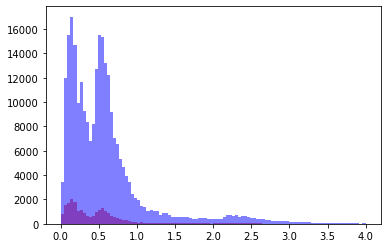

In [5]:
hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_out.hdf5', 'r')
y_array = np.asarray(hf['specz_redshift'][0:])[..., None]
hf.close()
plt.hist(y_array, bins = 100, color = 'red', alpha = 0.5)
hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_in.hdf5', 'r')
y_array = np.asarray(hf['specz_redshift'][0:])[..., None]
hf.close()
plt.hist(y_array, bins = 100, color = 'blue', alpha = 0.5)
plt.show()

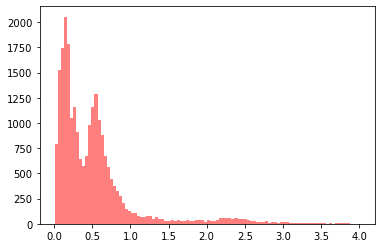

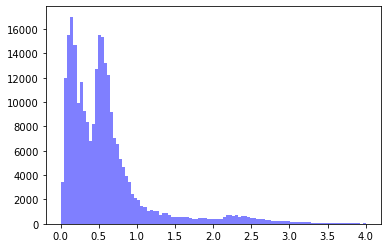

In [6]:
hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_out.hdf5', 'r')
y_array = np.asarray(hf['specz_redshift'][0:])[..., None]
hf.close()
plt.hist(y_array, bins = 100, color = 'red', alpha = 0.5)
plt.show()
hf = h5py.File('/data/HSC/HSC_v6/step3/127x127_in.hdf5', 'r')
y_array = np.asarray(hf['specz_redshift'][0:])[..., None]
hf.close()
plt.hist(y_array, bins = 100, color = 'blue', alpha = 0.5)
plt.show()

In [7]:
n = 10000
t = 2000
v = 2000

In [8]:
hf_train = h5py.File('/data/HSC/HSC_v6/step3/127x127_0.2_in_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step3/127x127_0.2_in_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step3/127x127_0.2_in_validation_small.hdf5', 'r')
x_train = np.asarray(np.transpose(hf_train['image'][0:], (0, 2, 3, 1)))
x_test = np.asarray(np.transpose(hf_test['image'][0:], (0, 2, 3, 1)))
x_validation = np.asarray(np.transpose(hf_validation['image'][0:], (0, 2, 3, 1)))
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
object_id_train = np.asarray(hf_train['object_id'][0:])
object_id = np.asarray(hf_test['object_id'][0:])
object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

In [9]:
hf_train_2 = h5py.File('/data/HSC/HSC_v6/step3/127x127_0.2_out_training_small.hdf5', 'r')
hf_test_2 = h5py.File('/data/HSC/HSC_v6/step3/127x127_0.2_out_testing_small.hdf5', 'r')
hf_validation_2 = h5py.File('/data/HSC/HSC_v6/step3/127x127_0.2_out_validation_small.hdf5', 'r')
x_train_2 = np.asarray(np.transpose(hf_train_2['image'][0:], (0, 2 ,3 ,1)))
x_test_2 = np.asarray(np.transpose(hf_test_2['image'][0:], (0, 2, 3, 1)))
x_validation_2 = np.asarray(np.transpose(hf_validation_2['image'][0:], (0, 2, 3, 1)))
x_train_2 = np.true_divide(x_train_2, max_value)
x_test_2 = np.true_divide(x_test_2, max_value)
x_validation_2 = np.true_divide(x_validation_2, max_value)
y_train_2 = np.asarray(hf_train_2['specz_redshift'][0:])[..., None]
y_test_2 = np.asarray(hf_test_2['specz_redshift'][0:])[..., None]
y_validation_2 = np.asarray(hf_validation_2['specz_redshift'][0:])[..., None]
object_id_train_2 = np.asarray(hf_train_2['object_id'][0:])
object_id_2 = np.asarray(hf_test_2['object_id'][0:])
object_id_validation_2 = np.asarray(hf_validation_2['object_id'][0:])
hf_train_2.close()
hf_test_2.close()
hf_validation_2.close()

In [10]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype = dtype, initializer = lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable = True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t[ ..., : n],
                       scale = tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims = 1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype = dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc = t, scale = 0.01),
            reinterpreted_batch_ndims = 1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean = 0., stddev = 0.03)
    loc = tf.Variable(
        initial_value = loc_norm(shape = (n, ), dtype = dtype)
    )
    scale_norm = tf.random_normal_initializer(mean = -3., stddev = 0.1)
    scale = tf.Variable(
        initial_value = scale_norm(shape = (n, ), dtype = dtype)
    )
    return tf.concat([loc, scale], 0)

kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [11]:
import keras
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

In [12]:
model_1 = Sequential([
    InputLayer(input_shape = (127, 127, 5)),
    Conv2D(32, kernel_size = (3, 3), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (2, 2), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu'),
    Flatten(),
    Dense(512),
    Dense(128),
    Dense(1)
])

model_1.build((10000, 127, 127, 5))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (10000, 127, 127, 5)      0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (10000, 125, 125, 32)     1472      
_________________________________________________________________
module_wrapper_2 (ModuleWrap (10000, 62, 62, 32)       0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (10000, 61, 61, 32)       4128      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (10000, 30, 30, 32)       0         
_________________________________________________________________
module_wrapper_5 (ModuleWrap (10000, 28, 28, 32)       9248      
_________________________________________________________________
module_wrapper_6 (ModuleWrap (10000, 27, 27, 32)       4

In [13]:
model_2 = Sequential([
    InputLayer(input_shape = (127, 127, 5)),
    Conv2D(32, kernel_size = (3, 3), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (2, 2), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu'),
    Flatten(),
    Dense(512),
    Dense(128),
    Dense(1)
])

model_2.build((10000, 127, 127, 5))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_11 (ModuleWra (10000, 127, 127, 5)      0         
_________________________________________________________________
module_wrapper_12 (ModuleWra (10000, 125, 125, 32)     1472      
_________________________________________________________________
module_wrapper_13 (ModuleWra (10000, 62, 62, 32)       0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (10000, 61, 61, 32)       4128      
_________________________________________________________________
module_wrapper_15 (ModuleWra (10000, 30, 30, 32)       0         
_________________________________________________________________
module_wrapper_16 (ModuleWra (10000, 28, 28, 32)       9248      
_________________________________________________________________
module_wrapper_17 (ModuleWra (10000, 27, 27, 32)      

In [14]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mse', metrics = [keras.metrics.RootMeanSquaredError()])
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mse', metrics = [keras.metrics.RootMeanSquaredError()])

In [15]:
run = neptune.init(
    name = "Filtered Data Test",
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-50


Info (NVML): RM has detected an NVML/RM version mismatch.. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [16]:
# import tensorboard

# model_name = 'HSC_v6_BCNN_v5'

# checkpoint_filepath = os.path.join('/models/', model_name) + '/' + model_name

# weights_path = os.path.join('/models/', model_name) + '/weights'

# log_dir = os.path.join('/logs/', model_name)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, verbose = 1, save_freq = 150*250)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

lr_callback = ReduceLROnPlateau()

neptune_callback = NeptuneCallback(run = run)

In [ ]:
model_1.fit(x = x_train, y = y_train, epochs = 600, shuffle = True, verbose = 1, validation_data = (x_validation, y_validation), callbacks = [neptune_callback, lr_callback])
model_2.fit(x = x_train_2, y = y_train_2, epochs = 600, shuffle = True, verbose = 1, validation_data = (x_validation_2, y_validation_2), callbacks = [neptune_callback, lr_callback])

Epoch 1/600


In [ ]:
# model_2.save_weights(weights_path.format(epoch = 900))

In [ ]:
# model_2.load_weights(weights_path)

In [ ]:
photoz = []

for i in range(t):
    photoz.append(model_1.predict(np.array([x_test[i]]))[0][0])

photoz = np.asarray(photoz).astype('float32')

In [ ]:
photoz_2 = []

for i in range(t):
    photoz_2.append(model_2.predict(np.array([x_test_2[i]]))[0][0])

photoz_2 = np.asarray(photoz_2).astype('float32')

photoz_train = []

for i in range(n):
    photoz_train.append(model_2(np.array([x_train[i]])).mean()[0][0])

photoz_train = np.asarray(photoz_train).astype('float32')

photoz_validation = []

for i in range(v):
    photoz_validation.append(model_2(np.array([x_validation[i]])).mean()[0][0])

photoz_validation = np.asarray(photoz_validation).astype('float32')

In [ ]:
specz = np.asarray(y_test)[:,0]
specz_2 = np.asarray(y_test_2)[:,0]
# specz_train = np.asarray(y_train)[:,0]
# specz_validation = np.asarray(y_validation)[:,0]

In [ ]:
photoz_err = []

for i in range(t):
    photoz_err.append(model_1.predict(np.array([x_test[i]]))[0][0] / 2)

In [ ]:
photoz_err_2 = []

for i in range(t):
    photoz_err_2.append(model_2.predict(np.array([x_test_2[i]]))[0][0] / 2)

photoz_err_train = []

for i in range(n):
    photoz_err_train.append(model_2(np.array([x_train[i]])).stddev()[0][0])

photoz_err_validation = []

for i in range(v):
    photoz_err_validation.append(model_2(np.array([x_validation[i]])).stddev()[0][0])

In [ ]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([specz, photoz])).astype('float32')
z = gaussian_kde(xy)(xy)
xy_2 = np.asarray(np.vstack([specz_2, photoz_2])).astype('float32')
z_2 = gaussian_kde(xy_2)(xy_2)

In [ ]:
import seaborn as sns
z_max = 4
sns.set(rc = {'figure.figsize': (10, 10), 'lines.markersize': 20})
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(specz, photoz, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [ ]:
fig, ax = plt.subplots()
scatter_plot = ax.scatter(specz_2, photoz_2, c = z_2, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

sns.set(rc={'figure.figsize':(10, 10), 'lines.markersize':20})
plt.rcParams.update({'font.size': 100})
sns.set(font_scale=3)

data = {'BCNN':10.7, 'BNN':19.7, 'Mizuki':27.4,
        'DEmP':25}
models_list = list(data.keys())
outlier_rates = list(data.values())

plt.bar(models_list, outlier_rates, color=('blue', 'red', 'red', 'red'))
plt.plot([-.5, 3.5], [15, 15], color = 'black', linestyle = 'dashed')
plt.title("Outlier Rates")
plt.ylabel("% Outlier Rate")
plt.xlabel("Model Type")
plt.show()

In [ ]:
overlap = 0
overlap_array = []
for i in range(0,t):
    if np.abs(specz[i]-photoz[i])<=photoz_err[i]:
        overlap += 1
        overlap_array.append(1)
    else:
        overlap_array.append(0)

In [ ]:
overlap_2 = 0
overlap_array_2 = []
for i in range(0,t):
    if np.abs(specz_2[i]-photoz_2[i])<=photoz_err[i]:
        overlap_2 += 1
        overlap_array_2.append(1)
    else:
        overlap_array_2.append(0)

In [ ]:
fig, ax = plt.subplots()
display_size = 1000
scatter_plot = ax.scatter(specz[:display_size], photoz[:display_size], c = z[:display_size], s = 4, edgecolor = None, zorder = 2)
error_plot = ax.errorbar(specz[:display_size], photoz[:display_size], yerr = photoz_err[:display_size], fmt = "o", markersize = 0, color = 'blue', elinewidth = 1, zorder = 1)
plt.title('Prediction with error, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max], color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: "+str(overlap_2/t))

In [ ]:
combined_array = np.transpose(np.vstack((specz, photoz, photoz_err, overlap_array))) 
combined_array_2 = np.transpose(np.vstack((specz_2, photoz_2, photoz_err_2, overlap_array_2)))

In [ ]:
sorted_combined_array = sorted(combined_array, key=lambda x: x[0])
sorted_combined_array_2 = sorted(combined_array_2, key=lambda x: x[0])

In [ ]:
bins = int(z_max*5)
splitted_sorted_combined_array = np.array_split(sorted_combined_array, bins)
coverage = []
for i in range(0, bins):
    bins_count = 0
    for j in range(0,len(splitted_sorted_combined_array[i])):
        if splitted_sorted_combined_array[i][j][3] == 1:
            bins_count += 1
    coverage.append(bins_count/len(splitted_sorted_combined_array[i])/0.6827)

In [ ]:
bins_2 = int(z_max*5)
splitted_sorted_combined_array_2 = np.array_split(sorted_combined_array_2, bins_2)
coverage_2 = []
for i in range(0, bins_2):
    bins_count_2 = 0
    for j in range(0,len(splitted_sorted_combined_array_2[i])):
        if splitted_sorted_combined_array_2[i][j][3] == 1:
            bins_count_2 += 1
    coverage_2.append(bins_count_2/len(splitted_sorted_combined_array_2[i])/0.6827)
x_array = np.arange(0, z_max, z_max/bins_2)

In [ ]:
plt.plot(x_array, coverage, c = 'blue')
plt.plot(x_array, coverage_2, c = 'red')
plt.title('Coverage')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0, 1.5])
plt.plot([0, 4], [1, 1], color = 'black', linestyle = 'dashed')
print("Filtered Coverage: "+str(overlap/t))
print("Coverage: "+str(overlap_2/t))

In [ ]:
mean_array = []
for i in range(0, bins):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array[i])):
        bias = (splitted_sorted_combined_array[i][j][1]-splitted_sorted_combined_array[i][j][0])/(1 + splitted_sorted_combined_array[i][j][0])
        total += bias/(1 + splitted_sorted_combined_array[i][j][0])
    mean_array.append(total/len(splitted_sorted_combined_array[i]))
x_array = np.arange(0, z_max, z_max/bins)

In [ ]:
mean_array_2 = []
for i in range(0, bins_2):
    total_2 = 0
    for j in range(0, len(splitted_sorted_combined_array_2[i])):
        bias_2 = (splitted_sorted_combined_array_2[i][j][1]-splitted_sorted_combined_array_2[i][j][0])/(1 + splitted_sorted_combined_array_2[i][j][0])
        total_2 += bias_2/(1 + splitted_sorted_combined_array_2[i][j][0])
    mean_array_2.append(total_2/len(splitted_sorted_combined_array_2[i]))

In [ ]:
error_array = []
for i in range(0,bins):
    error_total = 0
    for j in range(0,len(splitted_sorted_combined_array[i])):
        error_total += splitted_sorted_combined_array[i][j][2]
    error_array.append(error_total/len(splitted_sorted_combined_array[i]))

In [ ]:
error_array_2 = []
for i in range(0,bins_2):
    error_total_2 = 0
    for j in range(0,len(splitted_sorted_combined_array_2[i])):
        error_total_2 += splitted_sorted_combined_array_2[i][j][2]
    error_array_2.append(error_total_2/len(splitted_sorted_combined_array_2[i]))

In [ ]:
sns.set(rc={'figure.figsize':(5, 5), 'lines.markersize':40})
plt.rcParams.update({'font.size': 40})
plt.errorbar(x_array, mean_array, yerr = error_array, fmt = "o", color = 'blue', markersize = 4, elinewidth = 2)
plt.errorbar(x_array, mean_array_2, yerr = error_array_2, fmt = "o", color = 'red', markersize = 4, elinewidth = 2)
plt.title(' ')
plt.xlabel('True Redshift')
plt.ylabel('Bias (Predicted - True)')
plt.plot([0, z_max], [0, 0], color = 'black')
plt.plot([0, z_max], [0.003, 0.003], color = 'black', linestyle = 'dashed')
plt.plot([0, z_max], [-0.003, -0.003], color = 'black', linestyle = 'dashed')
plt.ylim([-0.1, 0.1])
plt.show()

In [ ]:
combined_outlier_array_2 = np.transpose(np.vstack((specz_2, photoz_2, photoz_err_2)))
sorted_combined_outlier_array_2 = sorted(combined_outlier_array_2, key = lambda x: x[0])
bins_outlier = int(z_max * 20)
splitted_sorted_combined_outlier_array_2 = np.array_split(sorted_combined_outlier_array_2, bins_outlier)
outlier_array_2 = []
outlier_count_total_2 = 0
for i in range(0, bins_outlier):
    outlier_count_2 = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array_2[i])):
        if np.abs(splitted_sorted_combined_outlier_array_2[i][j][1] - splitted_sorted_combined_outlier_array_2[i][j][0]) >= 3 * splitted_sorted_combined_outlier_array_2[i][j][2]:
            outlier_count_2 += 1
            outlier_count_total_2 += 1
    outlier_array_2.append(outlier_count_2 / len(specz) * bins_outlier)

combined_outlier_array = np.transpose(np.vstack((specz, photoz, photoz_err)))
sorted_combined_outlier_array = sorted(combined_outlier_array, key = lambda x: x[0])
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array, bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0, bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] - splitted_sorted_combined_outlier_array[i][j][0]) >= 3 * splitted_sorted_combined_outlier_array[i][j][2]:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count / len(specz) * bins_outlier)

x_array_outlier = np.arange(0, z_max, z_max / bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.plot(x_array_outlier, outlier_array_2, c = 'red')
plt.title('')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0, z_max])
plt.ylim([0, 1 / 2])
plt.show()

print("Outlier Rate Filtered: "+str(outlier_count_total/len(specz)))
print("Outlier Rate: "+str(outlier_count_total_2/len(specz)))

In [ ]:
combined_outlier_array = np.transpose(np.vstack((specz, np.subtract(photoz, specz))))
sorted_combined_outlier_array = sorted(combined_outlier_array, key = lambda x: x[0])
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array, bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0, bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1] / (splitted_sorted_combined_outlier_array[i][j][0] + 1)) >= .15:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count / len(specz) * bins_outlier)

combined_outlier_array_2 = np.transpose(np.vstack((specz_2, np.subtract(photoz_2, specz_2))))
sorted_combined_outlier_array_2 = sorted(combined_outlier_array_2, key = lambda x: x[0])
splitted_sorted_combined_outlier_array_2 = np.array_split(sorted_combined_outlier_array_2, bins_outlier)
outlier_array_2 = []
outlier_count_total_2 = 0
for i in range(0, bins_outlier):
    outlier_count_2 = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array_2[i])):
        if np.abs(splitted_sorted_combined_outlier_array_2[i][j][1] / (splitted_sorted_combined_outlier_array_2[i][j][0] + 1)) >= .15:
            outlier_count_2 += 1
            outlier_count_total_2 += 1
    outlier_array_2.append(outlier_count_2 / len(specz_2) * bins_outlier)

plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.plot(x_array_outlier, outlier_array_2, c = 'red')

plt.title('')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0,z_max])
plt.ylim([0,1/2])
plt.show()

print("Outlier Rate Filtered: "+str(outlier_count_total/len(specz)))
print("Outlier Rate: "+str(outlier_count_total_2/len(specz)))

uncertains = []
for i in range(0, len(photoz_err)):
    if photoz_err[i].numpy() >= 1:
        uncertains.append(i)
        print("Object ID: " + str(object_id[i]) + ", Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

In [ ]:
plt.imshow(x_train_2[6][:,:,0])

check = 2
current = uncertains[check]
print("Object ID: " + str(object_id[current]) + ", Spectro_z: " + str(specz[current]) + ", Photo_z: " + str(photoz[current]) + ", Photo_z_err: " + str(photoz_err[current].numpy()))
plt.imshow(x_test[current][:,:,0])
plt.grid(False)

biases = []
for i in range(0, len(photoz)):
    if np.abs(photoz[i]-specz[i]) >= 1 and photoz_err[i].numpy() <= 0.5:
        biases.append(i)
        print("Object ID: " + str(object_id[i]) + ", Spectro_z: " + str(specz[i]) + ", Photo_z: " + str(photoz[i]) + ", Photo_z_err: " + str(photoz_err[i].numpy()))

check_bias = 3
current_bias = biases[check_bias]
print("Object ID: " + str(object_id[current_bias]) + ", Spectro_z: " + str(specz[current_bias]) + ", Photo_z: " + str(photoz[current_bias]) + ", Photo_z_err: " + str(photoz_err[current_bias].numpy()))
plt.imshow(x_test[current_bias][:,:,0])
plt.grid(False)

In [ ]:
# END